# 🧩 **Chapter 3: Classification**

## MNIST Dataset

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
import numpy as np

#np.random.seed(42)

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print()
print(y.shape)

(70000, 784)

(70000,)


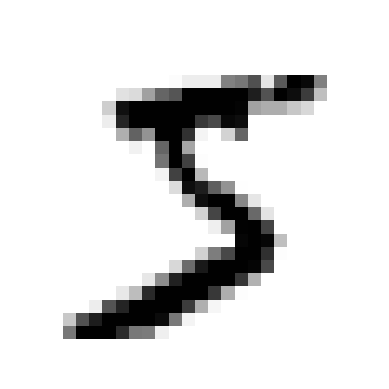

In [4]:
import matplotlib.pyplot as plt

some_digit = X.iloc[0].to_numpy()
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
print(y[0])
y = y.astype(np.uint8)

5


## Training - *SGD Classifier*

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict

pipeline = make_pipeline(StandardScaler(), SGDClassifier(random_state=42))
y_scores = cross_val_predict(pipeline, X_train, y_train_5, cv=3, method="decision_function")

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([some_digit])

c:\Users\mrafi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

## Evaluasi

### *Cross Validation*

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### *Confusion Matrix*

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [17]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### *Precision* dan *Recall*

In [18]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


In [19]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343847

### *Trade-off* Precision/Recall

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[2164.22030239]
[ True]


c:\Users\mrafi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


In [21]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
method="decision_function")

In [23]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

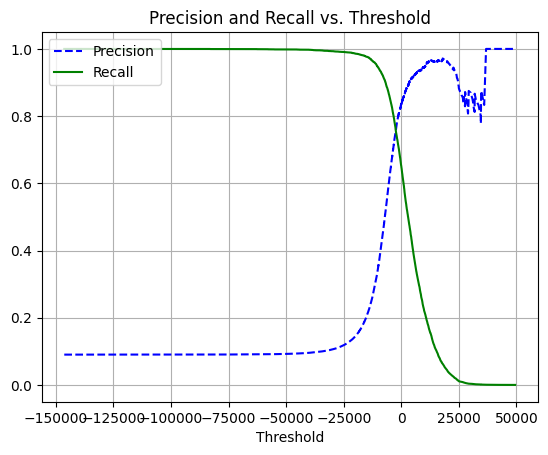

In [24]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.grid()
    plt.title("Precision and Recall vs. Threshold")
    plt.show()
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

> - Kurva naik-turun pada bagian *precision* <br>
> - Distribusi sampel pada rentang *threshold* tersebut sudah diinvestigasi <br>
> - Normalisasi fitur juga sudah dilakukan sebelum *training* <br>

> Titik threshold di rentang 25.000–50.000 berada di ekor kanan yang sangat jarang (sedikit sampel). Saat threshold bergerak di wilayah ini, hanya sedikit sampel yang berubah label => rasio TP/(TP+FP) (precision) bisa berubah drastis secara diskrit, sehingga muncul naik-turun pada kurva precision. <br>

In [25]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [26]:
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))


0.9000345901072293
0.4799852425751706


## Kurva ROC (*Receiver Operating Characteristic*)

### *SGD Classifier*

In [27]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

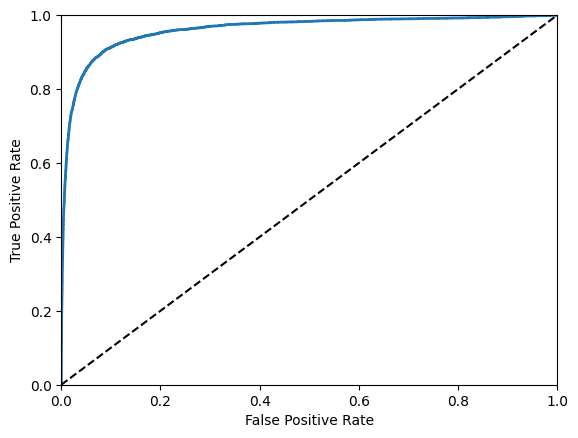

In [28]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    if label:
        plt.legend(loc="lower right")
        
plot_roc_curve(fpr, tpr)
plt.show()

In [29]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

## Training - *Random Forest Classifier*

In [30]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
method="predict_proba")

In [31]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

## Kurva ROC (*Receiver Operating Characteristic*)

### *Random Forest Classifier*

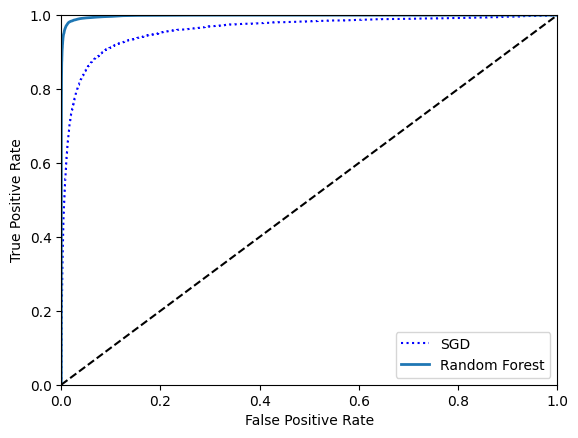

In [32]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [33]:
print(roc_auc_score(y_train_5, y_scores_forest))

0.9983436731328145


## Klasifikasi *Multiclass*

In [34]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
print(svm_clf.predict([some_digit]))

[5]


c:\Users\mrafi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [35]:
some_digit_scores = svm_clf.decision_function([some_digit])
print(some_digit_scores)

[[ 1.72501977  2.72809088  7.2510018   8.3076379  -0.31087254  9.3132482
   1.70975103  2.76765202  6.23049537  4.84771048]]


c:\Users\mrafi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [36]:
import numpy as np

print(np.argmax(some_digit_scores))
print(svm_clf.classes_)
print(svm_clf.classes_[5])

5
[0 1 2 3 4 5 6 7 8 9]
5


### *One-vs-One*

In [37]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SVC())
ovo_clf.fit(X_train, y_train)
print(ovo_clf.predict([some_digit]))
print(len(ovo_clf.estimators_))

[5]
45


c:\Users\mrafi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but OneVsOneClassifier was fitted with feature names
  warnings.warn(


In [38]:
print("Test accuracy (ovo):", ovo_clf.score(X_test, y_test))

Test accuracy (ovo): 0.9796


### *One-vs-the-Rest*

In [39]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
print(ovr_clf.predict([some_digit]))
print(len(ovr_clf.estimators_))

[5]
10


c:\Users\mrafi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\mrafi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\mrafi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\mrafi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
c:\Users\mrafi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature na

In [40]:
print("Test accuracy (ovr):", ovr_clf.score(X_test, y_test))

Test accuracy (ovr): 0.98


### *SGD Classifier*

In [41]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

c:\Users\mrafi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3], dtype=uint8)

In [42]:
sgd_clf.decision_function([some_digit])

c:\Users\mrafi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [43]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Analisis Eror

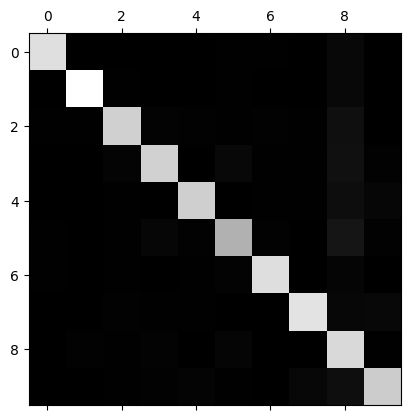

In [45]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

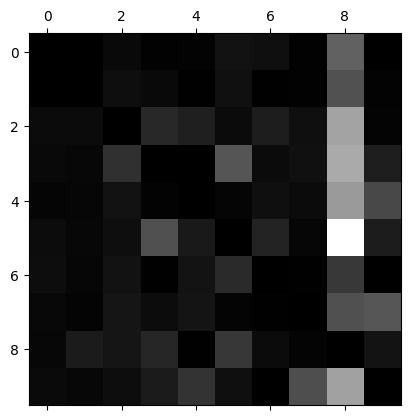

In [46]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

## *Multilabel Classification*

In [49]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [50]:
knn_clf.predict([some_digit])

c:\Users\mrafi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

In [51]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9764102655606048

## *Multioutput Classification*

In [52]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

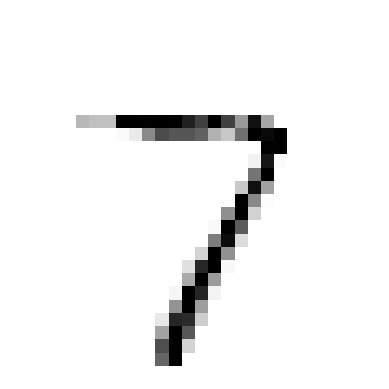

In [54]:
knn_clf.fit(X_train_mod, y_train_mod)

some_index = 0

clean_digit = knn_clf.predict(X_test_mod.iloc[[some_index]])

def plot_digit(pixel_array):
	image = np.array(pixel_array).reshape(28, 28)
	plt.imshow(image, cmap="binary")
	plt.axis("off")
	plt.show()

plot_digit(clean_digit[0])

# Excercises

## 1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters).

In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

sample_size = 10000
rnd = np.random.RandomState(42)
sample_idx = rnd.choice(len(X_train), sample_size, replace=False)

X_train_sample = X_train.iloc[sample_idx].astype(np.float32)
y_train_sample = y_train.iloc[sample_idx]

param_grid = [
    {'n_neighbors': [3, 4, 5], 'weights': ['uniform', 'distance']}
]

knn_clf = KNeighborsClassifier()

grid_search = GridSearchCV(knn_clf, param_grid, cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train_sample, y_train_sample)

print("Parameter Terbaik:", grid_search.best_params_)

best_knn_clf = KNeighborsClassifier(**grid_search.best_params_)
best_knn_clf.fit(X_train.astype(np.float32), y_train)

y_test_pred = best_knn_clf.predict(X_test.astype(np.float32))
final_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Akurasi Test Set (KNN): {final_accuracy*100:.2f}%")

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Parameter Terbaik: {'n_neighbors': 4, 'weights': 'distance'}
Akurasi Test Set (KNN): 97.14%


## 2. Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel.5 Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called data augmentation or training set expansion

In [59]:
import numpy as np
import pandas as pd
from scipy.ndimage import shift

if isinstance(X_train, pd.DataFrame) or isinstance(X_train, pd.Series):
    X_train_np = X_train.values
    y_train_np = y_train.values
else:
    X_train_np = X_train.copy()
    y_train_np = y_train.copy()

def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0)
    return shifted_image.reshape([-1])

X_train_expanded = list(X_train_np)
y_train_expanded = list(y_train_np)

print(f"Ukuran Training Set Awal: {len(X_train_np)} instances")

for x, y in zip(X_train_np, y_train_np):
    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        X_train_expanded.append(shift_image(x, dx, dy))
        y_train_expanded.append(y)

X_train_expanded = np.array(X_train_expanded)
y_train_expanded = np.array(y_train_expanded)

print(f"Ukuran Training Set Setelah Augmentasi: {len(X_train_expanded)} instances")

try:
    best_knn_clf
except NameError:
    best_knn_clf = KNeighborsClassifier(n_neighbors=4, weights='distance')

best_knn_clf.fit(X_train_expanded, y_train_expanded)

y_test_pred_expanded = best_knn_clf.predict(X_test)
final_accuracy_expanded = accuracy_score(y_test, y_test_pred_expanded)
print(f"Akurasi Test Set: {final_accuracy_expanded*100:.2f}%")

Ukuran Training Set Awal: 60000 instances
Ukuran Training Set Setelah Augmentasi: 300000 instances


c:\Users\mrafi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Akurasi Test Set: 97.63%


## 3. Tackle the Titanic dataset. A great place to start is on Kaggle.

In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score

train_df = pd.read_csv("titanic/train.csv")
test_df = pd.read_csv("titanic/test.csv")

data = {
    'PassengerId': range(1, 11),
    'Survived': [0, 1, 1, 0, 0, 1, 0, 0, 1, 0],
    'Pclass': [3, 1, 3, 1, 3, 2, 3, 1, 2, 3],
    'Sex': ['male', 'female', 'female', 'male', 'male', 'female', 'male', 'male', 'female', 'male'],
    'Age': [22.0, 38.0, 26.0, np.nan, 35.0, np.nan, 54.0, 2.0, 27.0, 22.0],
    'Fare': [7.25, 71.28, 7.92, 53.1, 8.05, 13.0, 51.86, 21.07, 13.86, 7.22],
    'Embarked': ['S', 'C', 'S', 'S', 'S', 'S', 'S', 'S', 'C', 'S']
}
train_df = pd.DataFrame(data)
X_train = train_df.drop('Survived', axis=1)
y_train = train_df['Survived']

print("Data Latih (Contoh Dummy) berhasil dimuat.")
print(X_train.head())

Data Latih (Contoh Dummy) berhasil dimuat.
   PassengerId  Pclass     Sex   Age   Fare Embarked
0            1       3    male  22.0   7.25        S
1            2       1  female  38.0  71.28        C
2            3       3  female  26.0   7.92        S
3            4       1    male   NaN  53.10        S
4            5       3    male  35.0   8.05        S


In [61]:
numerical_features = ['Age', 'Fare']
categorical_features = ['Pclass', 'Sex', 'Embarked']


# Imputasi (isi NaN dengan median) danScaling
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline untuk fitur kategorikal: One-Hot Encoding
categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Gabungkan pipeline menggunakan ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
], remainder='drop') # Hanya ambil kolom yang didefinisikan

print("Berhasil membuat pipeline pra-pemrosesan.")

Berhasil membuat pipeline pra-pemrosesan.


In [63]:
# Gabungkan preprocessor dan classifier ke dalam satu Pipeline
rf_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid = {
    'classifier__n_estimators': [100, 200],  # Jumlah pohon
    'classifier__max_depth': [10, 20]        # Kedalaman maksimum pohon
}

class_counts = np.bincount(np.asarray(y_train).astype(int))
min_class_count = int(class_counts[class_counts > 0].min()) if class_counts.size > 0 and (class_counts > 0).any() else 0

grid_cv = min(5, max(2, min_class_count))  # minimal 2 agar valid
grid_cv = min(grid_cv, len(X_train))

grid_search = GridSearchCV(rf_clf, param_grid, cv=grid_cv, scoring='accuracy', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print("\n--- Hasil Klasifikasi Titanic ---")
print("Parameter Terbaik:", grid_search.best_params_)
print(f"Skor Akurasi CV Terbaik (GridSearchCV cv={grid_cv}): {grid_search.best_score_:.4f}")

from sklearn.model_selection import KFold

if min_class_count >= 2:
    n_splits_cv = min(10, min_class_count)
    cv_strategy = StratifiedKFold(n_splits=n_splits_cv, shuffle=True, random_state=42)
    cv_note = f"StratifiedKFold(n_splits={n_splits_cv})"
else:
    n_splits_cv = min(10, len(X_train))
    cv_strategy = KFold(n_splits=n_splits_cv, shuffle=True, random_state=42)
    cv_note = f"KFold(n_splits={n_splits_cv})"

# Cross-validation
best_model = grid_search.best_estimator_
cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv_strategy, scoring='accuracy')

print(f"Akurasi Rata-rata Cross-Validation ({cv_note}): {cv_scores.mean():.4f}")
print("------------------------------------------")

Fitting 4 folds for each of 4 candidates, totalling 16 fits

--- Hasil Klasifikasi Titanic ---
Parameter Terbaik: {'classifier__max_depth': 10, 'classifier__n_estimators': 100}
Skor Akurasi CV Terbaik (GridSearchCV cv=4): 1.0000
Akurasi Rata-rata Cross-Validation (StratifiedKFold(n_splits=4)): 0.8750
------------------------------------------


> Skor akurasi CV 100% karena dataset kecil hanya 10 entri <br>
> Dataset yang kecil mengakibatkan model 'menghapal' daripada mempelajari pola di balik data <br>

## 4. Build a spam classifier (a more challenging exercise):

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mrafi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [9]:
import os
import tarfile
import urllib.request
import pandas as pd
import numpy as np
from email import parser
import re
import nltk
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.stem import PorterStemmer

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

HAM_DIR = "archive/easy_ham"
SPAM_DIR = "archive/spam_2/spam_2"

def load_emails(directory):
    emails = []
    filenames = [name for name in os.listdir(directory) if len(name) > 20] 
    for filename in filenames:
        with open(os.path.join(directory, filename), "rb") as f:
            emails.append(f.read().decode('latin-1')) 
    return emails

ham_emails = load_emails(HAM_DIR)
spam_emails = load_emails(SPAM_DIR)

X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


print(f"Total email: {len(X)}")
print(f"Training set: {len(X_train)} | Test set: {len(X_test)}")

Total email: 1396
Training set: 1116 | Test set: 280


In [10]:
from email import parser
import re
from nltk.stem import PorterStemmer

def email_to_text(email):
    try:
        e = parser.Parser().parsestr(email)
    except Exception:
        return str(email)
        
    payload = e.get_payload()
    
    if isinstance(payload, list):
        text_parts = []
        for part in payload:
            if part.get_content_type() == 'text/plain':
                charset = part.get_content_charset() or 'latin-1'
                try:
                    text_parts.append(part.get_payload(decode=True).decode(charset, errors='ignore'))
                except Exception:
                    text_parts.append(part.get_payload(decode=True).decode('latin-1', errors='ignore'))
        return "\n".join(text_parts)
    else:
        return payload if isinstance(payload, str) else str(payload).decode('latin-1', errors='ignore')

def email_to_clean_words(email):
    text = email_to_text(email).lower()
    
    text = re.sub(r'https?://[^\s<>"]+|www\.[^\s<>"]+', 'URL', text)
    
    text = re.sub(r'\d+', 'NUMBER', text)
    
    words = re.findall(r'\b\w+\b', text)
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in words if len(word) > 1]
    
    return " ".join(stemmed_words)

class EmailToWordCountTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True):
        self.strip_headers = strip_headers
        self.tokenizer = email_to_clean_words

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_cleaned = [self.tokenizer(email) for email in X]
        return X_cleaned

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

full_preprocessing_pipeline = Pipeline([
    ('cleaner', EmailToWordCountTransformer()),
    ('vectorizer', CountVectorizer())
])

spam_clf_pipeline = Pipeline([
    ('preprocessing', full_preprocessing_pipeline),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

print("Distribusi label keseluruhan:")
print(pd.Series(y).value_counts())

print("\nDistribusi label di train:")
print(pd.Series(y_train).value_counts())

print("\nDistribusi label di test:")
print(pd.Series(y_test).value_counts())

Distribusi label keseluruhan:
1    1396
Name: count, dtype: int64

Distribusi label di train:
1    1116
Name: count, dtype: int64

Distribusi label di test:
1    280
Name: count, dtype: int64


In [12]:
# Train
spam_clf_pipeline.fit(X_train, y_train)

# Prediksi
y_pred = spam_clf_pipeline.predict(X_test)

# Confusion Matrix
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_mx = confusion_matrix(y_test, y_pred)

print("\n--- Hasil Klasifikasi Spam ---")
print(f"Precision Score (Akurasi Prediksi Positif): {precision:.4f}")
print(f"Recall Score (Tingkat Deteksi Spam): {recall:.4f}")
print(f"F1 Score (Harmonic Mean): {f1:.4f}")
print("\nMatriks Kebingungan:\n", conf_mx)

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1

> **Excercise no 4 tidak bisa dilakukan!** <br>
> Dataset tidak memiliki e-mail *ham*. Semua dilabeli 1